# CS109a Milestone #4/#5

## Stephen Turban & Noah Yonack
### 11/28/16

**Prompt:**

For the upcoming milestone, we will build some baseline models with basic features. You are free to explore on your own to investigate which features are useful. Here are some examples to get you started:

1. "meta" features (e.g. as most of you discovered, essay length seems to be a good indicator of score)
2. Essay "content" features, where the content is given by the bag-of-words. I.e. Use CountVectorizer or TfidfVectorizer (I recommend TfidfVectorizer) to get a feature vector for each essay
3. Prompt content features.
4. Combinations of the above.

Always be sure to report train/test scores, and feel free to experiment with regularization, ngram size for vectorizers, etc.

Note: feature vectors you get from (2) and (3) will be sparse. Therefore in order to combine (2) with (1), you will need to make (1) sparse as well.

Let me know if your group wants to meet with me to discuss more in person.

In [3]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from scipy.stats import spearmanr
import sklearn.svm as svm
import scipy.sparse
%matplotlib inline

In [5]:
essay_df = pd.read_csv("datasets/training_set_rel3.tsv", delimiter="\t")
essay_df.head(2)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before vectorizing the text, we have a large number of obsvervations and only a few predictors.

In [6]:
essay_df.shape

(12976, 28)

Let's vectorize our text and use the individual words used in essays as predictors. For now, stick to n-grams of size 1 (unigrams).

In [164]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 1))
corpus = essay_df["essay"].values
essay_vector = vectorizer.fit_transform(corpus)
essay_vector = essay_vector.toarray()

Now we have a lot of predictors — 10,000. This means we'll need to use some sort of regularization or feature selection.

In [165]:
essay_vector.shape

(12976, 10017)

Let's also use essay length as a predictor.

In [166]:
# adding an essay length column to the dataframe
essay_df["essay_length"] = map(len, essay_df["essay"])

In [167]:
essay_df.head(2)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,essay_length
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1875
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2288


In [171]:
# let's work with Pandas dataframes to make things easier
feature_df = pd.DataFrame(essay_vector)

### We should also make sure to turn essay prompts into features.

In [10]:
def get_essay_x_y(data):
    '''
    A helper to separate the response variable (domain1_score) from
    the predictors.
    '''
    y = data["domain1_score"]
    X = data.drop("domain1_score", axis=1)
    return X, y

Let's use the essay set and length too.

In [175]:
feature_df["essay_set"] = essay_df["essay_set"]
feature_df["essay_length"] = essay_df["essay_length"]
feature_df["domain1_score"] = essay_df["domain1_score"]

As we can see, our data is sparse (mostly 0's). We'll need to use a sparse datatype before building any models.

In [30]:
print feature_df.shape
feature_df.head(2)

(12976, 10020)


,0,1,2,3,4,5,6,7,8,9,...,10010,10011,10012,10013,10014,10015,10016,essay_set,essay_length,domain1_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1875,8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2288,9


non-trivial features:

language model: prob. distribution of sequences of words. use language model as a proxy for gramatical correctness.

1. train a language model on corpus
2. model gives you pron. distribution over sequence
3. then score each essay using the model (use that as a feature)

another:
1. dot product between essay prompt and essay -- overlap between essay prompt and essay

latent semantic analysis: (nltk)
1. PCA on Tfidif matrix
2. given an essay, what's the essay that has the closest vector to it

PCA on sparse data (scipy).

In [114]:
X, y = get_essay_x_y(feature_df)

# make X sparse!
X = scipy.sparse.csr_matrix(X)

Let's start with a very basic model, using just the essay set and the essay length as predictors.

In [184]:
X = feature_df[["essay_set", "essay_length"]]
y = feature_df["domain1_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

ridge = Ridge()
ridge.fit(X_train, y_train)
print "R^2:", ridge.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(ridge.predict(X_test), y_test)

R^2: 0.640701827297
Spearman r:  (0.67031481375986735, 0.0)


Just these two features give a Spearman's r of about .68. Let's see if we can do better by including the vectorized text in the predictor set.

## Tuning Lasso and Ridge Models using K-Fold CV

Lasso will likely do better here due to the large number of (mostly unimportant) predictors, though we also try Ridge regression just in case.

In [155]:
lasso_alpha_list = [.0001, .001, .01 , 1]
lasso_r2_value = []
lasso_spearman_value = []

for alpha in lasso_alpha_list: 
    lasso_r2_temp = []
    lasso_spearman_temp = []
    
    print "Testing alpha = {0}".format(alpha)
    
    # gives us the different folds of our data to test against
    folds = KFold(X.shape[0], n_folds=2, shuffle=True)

    for train_indices, test_indices in folds:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        lasso = Lasso(alpha=alpha)
        
        # fit on the training data 
        lasso.fit(X_train, y_train)
        
        # calculate r^2
        lasso_r2_temp.append(lasso.score(X_test, y_test))
        spearman_r = scipy.stats.spearmanr(lasso.predict(X_test), y_test)
        print "Spearman_r:", spearman_r
        lasso_spearman_temp.append(spearman_r)
    
    lasso_r2_value.append(np.mean(lasso_r2_temp))
    lasso_spearman_value.append(np.mean(lasso_spearman_temp))

Testing alpha = 0.0001
Spearman_r: (0.81311741988677333, 0.0)
Spearman_r: (0.80481670399375893, 0.0)
Testing alpha = 0.001
Spearman_r: (0.80414458560281299, 0.0)
Spearman_r: (0.81593205875350039, 0.0)
Testing alpha = 0.01
Spearman_r: (0.78608949732426192, 0.0)
Spearman_r: (0.78293432574089061, 0.0)
Testing alpha = 1
Spearman_r: (0.67989680678487618, 0.0)
Spearman_r: (0.68553150332193868, 0.0)


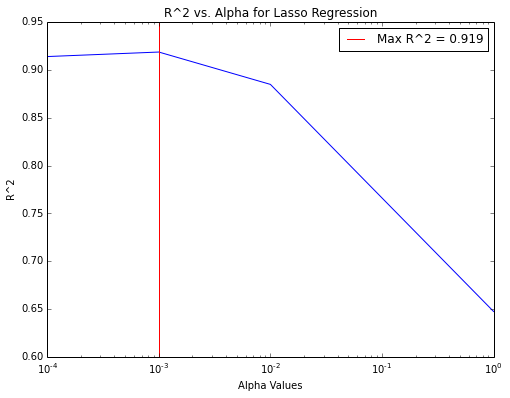

In [156]:
plt.figure(figsize=(8, 6))
plt.semilogx(lasso_alpha_list, lasso_r2_value)

best_index = np.argmax(np.array(lasso_r2_value))
plt.axvline(lasso_alpha_list[best_index], c='r', label="Max R^2 = {0:.3f}".format(lasso_r2_value[best_index]))

plt.title("R^2 vs. Alpha for Lasso Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("R^2")
plt.legend()
plt.show()

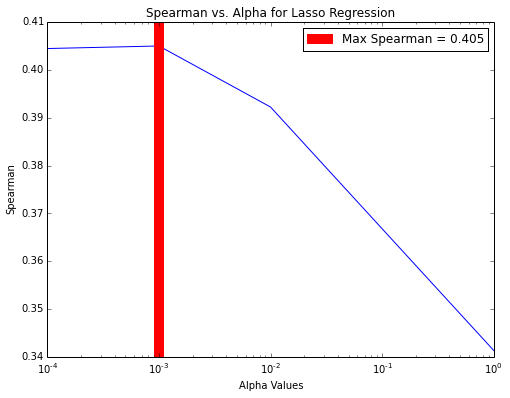

In [157]:
plt.figure(figsize=(8, 6))
plt.semilogx(lasso_alpha_list, lasso_spearman_value)

best_index = np.argmax(np.array(lasso_spearman_value))
plt.axvline(lasso_alpha_list[best_index], linewidth=10, c='r', label="Max Spearman = {0:.3f}".format(lasso_spearman_value[best_index]))

plt.title("Spearman vs. Alpha for Lasso Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("Spearman")
plt.legend()
plt.show()

### Tuning a Ridge Model via sklearn.linear_model.Ridge

In [138]:
alpha_list = [.0001, .001, .01, .1, 1, 10, 100]
ridge_r2_value = []
ridge_spearman_value = []

for alpha in alpha_list: 
    ridge_r2_temp = []
    ridge_spearman_temp = []
    
    print "Testing alpha = {0}".format(alpha)
    
    # gives us the different folds of our data to test against
    folds = KFold(X.shape[0], n_folds=2, shuffle=True)

    for train_indices, test_indices in folds:
        print "Testing a fold..."
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        ridge = Ridge(alpha=alpha, solver="sag")
        
        # fit on the training data 
        ridge.fit(X_train, y_train)
        
        # calculate r^2
        ridge_r2_temp.append(ridge.score(X_test, y_test))
        ridge_spearman_temp.append(scipy.stats.spearmanr(ridge.predict(X_test), y_test))
    
    ridge_r2_value.append(np.mean(ridge_r2_temp))
    ridge_spearman_value.append(np.mean(ridge_spearman_temp))

Testing alpha = 0.0001
Testing a fold...
Testing a fold...
Testing alpha = 0.001
Testing a fold...
Testing a fold...
Testing alpha = 0.01
Testing a fold...
Testing a fold...
Testing alpha = 0.1
Testing a fold...
Testing a fold...
Testing alpha = 1
Testing a fold...
Testing a fold...
Testing alpha = 10
Testing a fold...
Testing a fold...
Testing alpha = 100
Testing a fold...
Testing a fold...


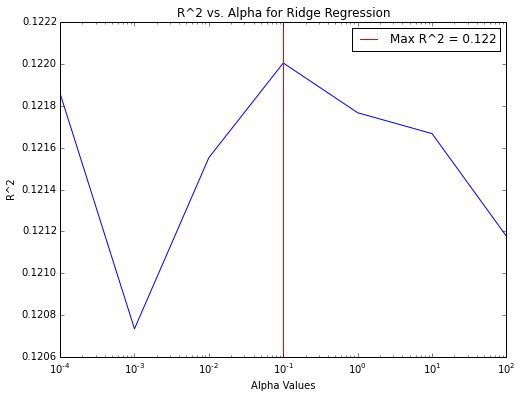

In [139]:
plt.figure(figsize=(8, 6))
plt.semilogx(alpha_list, ridge_r2_value)

best_index = np.argmax(np.array(ridge_r2_value))
plt.axvline(alpha_list[best_index], c='r', label="Max R^2 = {0:.3f}".format(ridge_r2_value[best_index]))

plt.title("R^2 vs. Alpha for Ridge Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("R^2")
plt.legend()
plt.show()

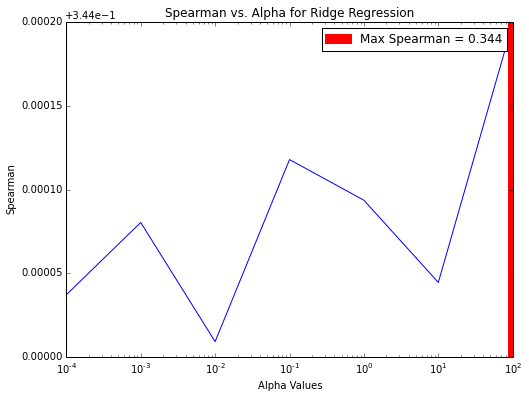

In [154]:
plt.figure(figsize=(8, 6))
plt.semilogx(alpha_list, ridge_spearman_value)

best_index = np.argmax(np.array(ridge_spearman_value))
plt.axvline(alpha_list[best_index], linewidth=10, c='r', label="Max Spearman = {0:.3f}".format(ridge_spearman_value[best_index]))

plt.title("Spearman vs. Alpha for Ridge Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("Spearman")
plt.legend()
plt.show()

In [198]:
alpha_list = [.001, .01, .1, 1, 10]
svm_r2_value = []
svm_spearman_value = []

for alpha in alpha_list: 
    svm_r2_temp = []
    svm_spearman_temp = []
    
    print "Testing alpha = {0}".format(alpha)
    
    # gives us the different folds of our data to test against
    folds = KFold(X.shape[0], n_folds=2, shuffle=True)

    for train_indices, test_indices in folds:
        print "Testing a fold..."
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        svm_model = svm.SVR(C=alpha)
        
        # fit on the training data 
        svm_model.fit(X_train, y_train)
        
        # calculate r^2
        svm_r2_temp.append(svm_model.score(X_test, y_test))
        svm_spearman_temp.append(scipy.stats.spearmanr(svm_model.predict(X_test), y_test))
    
    svm_r2_value.append(np.mean(svm_r2_temp))
    svm_spearman_value.append(np.mean(svm_spearman_temp))

Testing alpha = 0.001
Testing a fold...
Testing a fold...
Testing alpha = 0.01
Testing a fold...
Testing a fold...
Testing alpha = 0.1
Testing a fold...
Testing a fold...
Testing alpha = 1
Testing a fold...
Testing a fold...
Testing alpha = 10
Testing a fold...
Testing a fold...


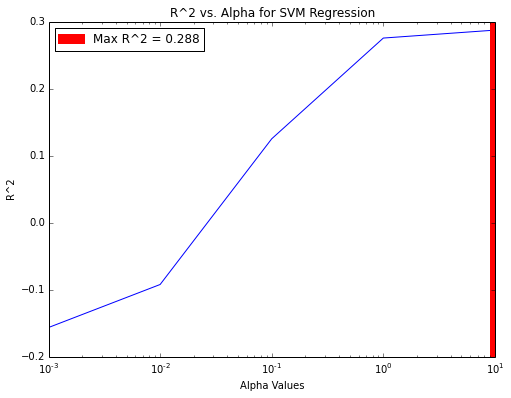

In [203]:
plt.figure(figsize=(8, 6))
plt.semilogx(alpha_list, svm_r2_value)

best_index = np.argmax(np.array(svm_r2_value))
plt.axvline(alpha_list[best_index], c='r', linewidth=10, label="Max R^2 = {0:.3f}".format(svm_r2_value[best_index]))

plt.title("R^2 vs. Alpha for SVM Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("R^2")
plt.legend(loc="upper left")
plt.show()

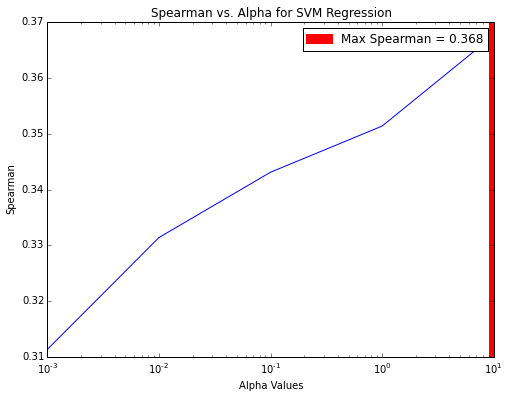

In [200]:
plt.figure(figsize=(8, 6))
plt.semilogx(alpha_list, svm_spearman_value)

best_index = np.argmax(np.array(svm_spearman_value))
plt.axvline(alpha_list[best_index], linewidth=10, c='r', label="Max Spearman = {0:.3f}".format(svm_spearman_value[best_index]))

plt.title("Spearman vs. Alpha for SVM Regression") 
plt.xlabel("Alpha Values")
plt.ylabel("Spearman")
plt.legend()
plt.show()

# Bare Model

In [209]:
r2_value = []
spearman_value = []

X = feature_df[["essay_set", "essay_length"]]
y = feature_df["domain1_score"]

# gives us the different folds of our data to test against
folds = KFold(X.shape[0], n_folds=5, shuffle=True)

for train_indices, test_indices in folds:
    X_train, X_test = X.ix[train_indices], X.ix[test_indices]
    y_train, y_test = y.ix[train_indices], y.ix[test_indices]

    linreg = LinearRegression()

    # fit on the training data 
    linreg.fit(X_train, y_train)
    
    r2_value.append(linreg.score(X_test, y_test))
    spearman_value.append(scipy.stats.spearmanr(linreg.predict(X_test), y_test))

r2 = np.mean(r2_value)
spearman = np.mean(spearman_value)

print "R^2 of bare model:", r2
print "Spearman's r of bare model:", spearman

R^2 of bare model: 0.650051117756
Spearman's r of bare model: 0.330162252167


### Let's also see how certain models stand up to a normal train-test split, absent of CV.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Bare Model

In [206]:
X = feature_df[["essay_set", "essay_length"]]
y = feature_df["domain1_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

ridge = Lasso()
ridge.fit(X_train, y_train)
print "R^2:", ridge.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(ridge.predict(X_test), y_test)

R^2: 0.653271824735
Spearman r:  (0.68366943954683423, 0.0)


# Lasso

In [189]:
lasso = Lasso(alpha=10**-3)
lasso = lasso.fit(X_train, y_train)
print "R^2:", lasso.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(lasso.predict(X_test), y_test)

R^2: 0.636721861209
Spearman r:  (0.64854890783351926, 0.0)


# Ridge

In [204]:
ridge = Ridge(alpha=10**2, solver="sag")
ridge = ridge.fit(X_train, y_train)
print "R^2:", ridge.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(ridge.predict(X_test), y_test)

R^2: 0.118736443371
Spearman r:  (0.68856585567144157, 0.0)


# SVM

In [191]:
svr = svm.SVR()
svr.fit(X_train, y_train)
print "R^2:", svr.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(svr.predict(X_test), y_test)

R^2: 0.0403851167403
Spearman r:  (0.83159250533037232, 0.0)


# Reflections

Here is a summary of our CV-results:
    - Ridge (R^2 = .122, Spearman's r = .344)
    - Lasso (R^2 = .919, Spearman's r = .415)
    - SVM (R^2 = .288, Spearman's r = .368)
    - Bare Model (R^2 = .65, Spearman's r = 0.33)

While we normally look at R^2 to judge a model's accuracy, note that R^2 just tells us about the linear relationship between our prdeictors and our response. Thus, it's more informative to look at Spearman's r to see just how much the predictons match the actual y values.

As expected, Lasso does best when using cross validation (Spearman's r = .415).

Overall, it looks like our SVM model is also doing really well. This seems to align with what we see in the literature that SVM is a powerful predictor of bag-of-n-gram models.

## Milestone #5: Next Steps, Experimenting

### Let's try using ngrams of size 2

In [7]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 2))
corpus = essay_df["essay"].values
essay_vector = vectorizer.fit_transform(corpus)
essay_vector = essay_vector.toarray()

essay_df["essay_length"] = map(len, essay_df["essay"])

In [8]:
feature_df = pd.DataFrame(essay_vector)
feature_df["essay_set"] = essay_df["essay_set"]
feature_df["essay_length"] = essay_df["essay_length"]
feature_df["domain1_score"] = essay_df["domain1_score"]

In [11]:
X, y = get_essay_x_y(feature_df)

# make X sparse!
X = scipy.sparse.csr_matrix(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lasso = Lasso()
lasso.fit(X_train, y_train)
print "R^2:", lasso.score(X_test, y_test)
print "Spearman r: ", scipy.stats.spearmanr(lasso.predict(X_test), y_test)

R^2: 0.633313252677
Spearman r:  (0.68158167383186807, 0.0)


Interesting! It seems as if the lasso model that includes n_grams of size 2 (bigrams) does a little bit better than the lasso model with unigrams (compare this Spearman's r of .68 to the train-test-split Spearman's r of .64). That said, the Spearman r here is only .04 better than the unigram model, so we might choose to just include unigrams in order to maintain a more parsimonious model. This is definitely something that we'll explore in the next milestone!

We should also try incorporating prompt features into the model, which might add some signal.

Another question to consider is whether or not to use models that predict only discrete values instead of continuous ones. It doesn't make sense to predict an essay score as 6.4 when essay scores can either be 6 or 7, so maybe a better model will take that into account.

Also, it might make sense to try building models separately for each data set. The reason is that the scoring guidelines are different for each model. This is definitely something we should consider for the next round of work.